### Tiling and converting of mask

In [1]:
# Install needed Packages
%%capture
!pip install rasterio
!pip install geopandas
!pip install fastai --upgrade
!pip install geocube

In [2]:
# Import packages
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.ops import cascaded_union
from shapely.geometry import mapping, Point, Polygon
from geocube.api.core import make_geocube
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from fastai.vision.all import *
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create functions
def tile_img_msk(image_path, tile_size:int):
  "Tile images and masks into smaller tiles and save them"
  for fn in tqdm(image_path):
    output_path = fn.parent.parent

    # Create directories
    if not os.path.exists(output_path/'image_tiles test'):
      os.makedirs(output_path/'image_tiles test')
    if not os.path.exists(output_path/f'{mask_type}_mask_tiles test'):
      os.makedirs(output_path/f'{mask_type}_mask_tiles test')

    # Create mask for current image
    img = np.array(PILImage.create(fn))
    msk_fn = str(fn).replace('images', f'untiled masks/{mask_type}')
    msk = np.array(PILMask.create(msk_fn))
    x, y, _ = img.shape

    # Cut tiles and save them
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        msk_tile = msk[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        print(fn.name)
        Image.fromarray(img_tile).save(f'{output_path}/image_tiles test/{fn.name[:-4]}_{i}_{j}.png')
        Image.fromarray(msk_tile).save(f'{output_path}/{mask_type}_mask_tiles test/{fn.name[:-4]}_{i}_{j}.png')


def tile_img(image_path, output_path, tile_size:int, single = None):
  "Tile image into smaller tiles and save them"
  if single == False:
    for fn in tqdm(image_path):
      # Create directories
      if not os.path.exists(output_path):
        os.makedirs(output_path)

      # Create mask for current image
      img = np.array(PILImage.create(fn))
      x, y, _ = img.shape

      # Cut tiles and save them
      for i in range(x//tile_size):
        for j in range(y//tile_size):
          img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
          Image.fromarray(img_tile).save(f'{output_path}/{fn.name[:-4]}_{i}_{j}.png')
  if single == True:
    # Create directories
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    # Create mask for current image
    img = np.array(PILImage.create(image_path))
    x, y, _ = img.shape

    # Cut tiles and save them
    fn = image_path.split("/")[-1][:-4]
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{output_path}/{fn}_{i}_{j}.png')


def generate_mask(raster_path, shape_path, output_path = None, file_name = None):
    """Function that generates a binary mask from a vector file (shp or geojson)
    raster_path = path to the .tif;
    shape_path = path to the shapefile or GeoJson.
    output_path = Path to save the binary mask.
    file_name = Name of the file.
    """
    
    # load raster
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    
    #load shapefile
    train_df = gpd.read_file(shape_path)
    
    #Verify crs
    if train_df.crs != src.crs:
      print(f"Raster CRS: {src.crs}, Vector CRS: {train_df.crs}.\n Convert vector and raster to the same CRS.")
        
    # Generate the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []
        poly = cascaded_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append( ~ transform * tuple(i))
        new_poly = Polygon(poly_pts)
        return new_poly
    
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)
    
    if len(poly_shp) > 0:
        mask = rasterize(shapes=poly_shp, out_shape=im_size)
    else:
        mask = np.zeros(im_size)
    
    # Save or show mask
    mask = mask.astype("uint8")    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    if (output_path != None and file_name != None):
        os.chdir(output_path)
        with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
            dst.write(mask * 255, 1) # Change 255 to 1 if classes need to be 0 and 1
    else:
        return mask


def save_masks(images, mask, maskdir):
    if not os.path.exists(maskdir):
        os.makedirs(maskdir)
    for image in tqdm(images):
        if image.name.endswith((".TIF", ".tif")):
            shapes = image.name
            generate_mask(image, mask, maskdir, shapes)

 
def informal_pixels_from_directory(directory):
    output_dict = {}
    for file in os.listdir(tiled_masks_path):
        try:
            mask = rasterio.open(os.path.join(tiled_masks_path, file))
            mask = (mask).read()
            settlement_pixels = np.count_nonzero(mask == 1)
            total_pixels = mask.size
            settlement_share = settlement_pixels / total_pixels
            output_dict[file] = settlement_share
        except:
            continue
    return output_dict


def informal_pixels_from_file(file):
    output_dict = {}
    mask = rasterio.open(file)
    mask = mask.read()
    settlement_pixels = np.count_nonzero(mask == 1)
    total_pixels = mask.size
    settlement_share = settlement_pixels / total_pixels
    return settlement_share

In [ ]:
# Set type of imagery and mask to tile
imagery_type = "aerial" # "satellite"
mask_type = "buildings" # "settlements"

# Set directory containing images and size of tiles to produce
path = Path(f"/content/drive/MyDrive/Segmentation Data/{imagery_type}")
images_list = get_image_files(path/"images")

# Set mask path
if mask_type == "settlements":
  shp_path = f"{path}/untiled masks/shapefiles/BuildingFootprints_4326.shp"
elif mask_type == "buildings":
  shp_path = f"{path}/untiled masks/shapefiles/manually labelled/2019_10cm_RGB_BE_67.shp"

Visualise Shapefile

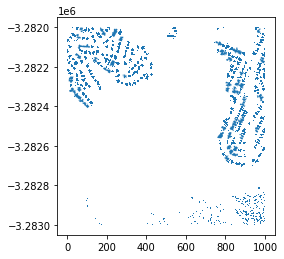

In [ ]:
mask_plot = gpd.read_file(shp_path)
mask_plot["geometry"].plot();

In [ ]:
tile(images_folder, tile_size)

Path('/content/drive/MyDrive/Segmentation Data/aerial/images/2019_10cm_RGB_BE_67.tif')

In [ ]:
print(f'Number of images: {len(images_list)}')
print(images_list[-1])

Number of images: 12
/content/drive/MyDrive/Segmentation Data/aerial/images/2019_10cm_RGB_BE_68.tif


Create Masks Corresponding to Selected Satellite Images

In [ ]:
# Create masks corresponding to satellite images
save_masks(images_list, shp_path, path/f'untiled masks/{mask_type} test')

Tile Selected Images and Corresponding Masks

In [ ]:
# Tile images and masks with a stride of 0 pixels
tile_size = 512
tile_img_msk(images_list, tile_size)

Tile Only Selected Image(s)

In [ ]:
# Tile images and masks with a stride of 0 pixels
tile_size = 500
output_path = path/"inference/input"
if not os.path.exists(str(output_path)):
  os.makedirs(str(output_path))

tile_img(str(images_list[-1]), output_path, tile_size, single = True)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
# Check to see if same number of image tiles and mask tiles were created
path = Path("/content/drive/MyDrive/Segmentation Data/aerial/")

print(len(get_image_files(mask_output_path)))
print(len(get_image_files(img_output_path)))

400
400


In [ ]:
# Share of pixels in overall mask that contain informal settlements
mask_share_informal = informal_pixels_from_file(mask_output_path)
round(mask_share_informal, 4) # 6.5 percent of the mask contain informal settlements

In [ ]:
# Share of tiles containing informal settlement pixels
tiles_share_informal = informal_pixels_from_directory(tiled_masks_path)
round(1-(sum(value == 0 for value in tiles_share_informal.values()))/len(tiles_share_informal), 3)
# 13.1 percent of the mask for tile R03C03 contain informal settlements

0.131